In [2]:
import torch
import torch.optim as optim
import os
import pandas as pd
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

Read csv files and clean some data

In [3]:
nodes_df = pd.read_csv('clean_uoft_nodes_v2.csv')

nodes_df.drop(['Unnamed: 0', 'BIRTH_DT', 'CUST_ADD_DT','NAME'],inplace=True,axis=1)
nodes_df=pd.get_dummies(nodes_df,columns=['OCPTN_NM','COUNTRY_RISK_INCOME','COUNTRY_RISK_RESIDENCY','GENDER'])
mapper={'low':0,'medium':1,'high':2}
nodes_df['RISK']=nodes_df['RISK'].map(mapper)

In [4]:
x=nodes_df.drop(['RISK'],axis=1)
y=nodes_df['RISK']

## Split dataset

In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30)

In [6]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(700000, 23) (300000, 23) (700000,) (300000,)


In [7]:
## balance the dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled=rus.fit_resample(x_train,y_train)

In [8]:
y_resampled.value_counts()

0    35008
1    35008
2    35008
Name: RISK, dtype: int64

#Standarize the dataset

In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
standard_x_train = pd.DataFrame(
    scaler.fit_transform(X_resampled),
    columns = X_resampled.columns, index=X_resampled.index)
standard_x_test = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns,index=x_test.index)

In [10]:
standard_x_train.head(2)

,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,...,OCPTN_NM_Low,OCPTN_NM_Moderate,COUNTRY_RISK_INCOME_High,COUNTRY_RISK_INCOME_Low,COUNTRY_RISK_INCOME_Moderate,COUNTRY_RISK_RESIDENCY_High,COUNTRY_RISK_RESIDENCY_Low,COUNTRY_RISK_RESIDENCY_Moderate,GENDER_Female,GENDER_Male
0,0.148499,0.124892,-0.445941,-0.655495,-0.410652,-0.502566,0.725523,-0.689279,0.281299,-0.719876,...,0.818237,-0.1335,-0.079826,0.085377,-0.030089,-0.129567,0.132797,-0.028627,-1.106772,1.106772
1,0.148499,0.124892,-0.445941,-0.900268,-1.012849,-0.832743,-0.952182,-0.685174,-0.533033,-0.785618,...,0.818237,-0.1335,-0.079826,0.085377,-0.030089,-0.129567,0.132797,-0.028627,0.903529,-0.903529


## Normalize the dataset

In [11]:
scaler = MinMaxScaler()
normalized_x_train = pd.DataFrame(
    scaler.fit_transform(standard_x_train),
    columns = standard_x_train.columns, index=standard_x_train.index)
normalized_x_test = pd.DataFrame(scaler.transform(standard_x_test),columns = standard_x_test.columns,index=standard_x_test.index)

In [12]:
normalized_x_train.head(2)

,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,...,OCPTN_NM_Low,OCPTN_NM_Moderate,COUNTRY_RISK_INCOME_High,COUNTRY_RISK_INCOME_Low,COUNTRY_RISK_INCOME_Moderate,COUNTRY_RISK_RESIDENCY_High,COUNTRY_RISK_RESIDENCY_Low,COUNTRY_RISK_RESIDENCY_Moderate,GENDER_Female,GENDER_Male
0,1.0,1.0,0.0,0.037364,0.088608,0.047040,0.216495,0.006000,0.188034,0.010376,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.006273,0.012658,0.006626,0.025773,0.006504,0.090598,0.003093,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [13]:
train_data=pd.concat([normalized_x_train,y_resampled],axis=1)
test_data=pd.concat([normalized_x_test,y_test],axis=1)

In [14]:
train_data

,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,...,OCPTN_NM_Moderate,COUNTRY_RISK_INCOME_High,COUNTRY_RISK_INCOME_Low,COUNTRY_RISK_INCOME_Moderate,COUNTRY_RISK_RESIDENCY_High,COUNTRY_RISK_RESIDENCY_Low,COUNTRY_RISK_RESIDENCY_Moderate,GENDER_Female,GENDER_Male,RISK
0,1.0,1.0,0.0,0.037364,0.088608,0.047040,0.216495,0.006000,0.188034,0.010376,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,1.0,1.0,0.0,0.006273,0.012658,0.006626,0.025773,0.006504,0.090598,0.003093,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,1.0,1.0,0.0,0.016045,0.050633,0.025515,0.097938,0.003985,0.225641,0.000967,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,1.0,1.0,0.0,0.010096,0.037975,0.003304,0.025773,0.005801,0.148718,0.012150,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,1.0,1.0,0.0,0.034153,0.088608,0.019616,0.118557,0.003451,0.227350,0.009532,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105019,0.0,1.0,1.0,0.101793,0.126582,0.142269,0.144330,0.009368,0.047863,0.021849,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2
105020,1.0,1.0,0.0,0.046336,0.037975,0.042584,0.072165,0.080916,0.058120,0.107343,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2
105021,1.0,1.0,0.0,0.229192,0.253165,0.158165,0.257732,0.088084,0.239316,0.070408,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2
105022,1.0,1.0,0.0,0.028744,0.037975,0.188097,0.221649,0.125669,0.316239,0.040911,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2


In [15]:
test_data

,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,...,OCPTN_NM_Moderate,COUNTRY_RISK_INCOME_High,COUNTRY_RISK_INCOME_Low,COUNTRY_RISK_INCOME_Moderate,COUNTRY_RISK_RESIDENCY_High,COUNTRY_RISK_RESIDENCY_Low,COUNTRY_RISK_RESIDENCY_Moderate,GENDER_Female,GENDER_Male,RISK
847706,1.0,1.0,0.0,0.045953,0.139241,0.008579,0.025773,0.001605,0.082051,0.006372,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
352543,1.0,1.0,0.0,0.005783,0.037975,0.014229,0.061856,0.000867,0.001709,0.010142,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
949462,1.0,1.0,0.0,0.291934,0.341772,0.146040,0.164948,0.033381,0.068376,0.047798,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
567990,1.0,1.0,0.0,0.028598,0.075949,0.035959,0.154639,0.008159,0.177778,0.011430,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
958742,1.0,1.0,0.0,0.128152,0.139241,0.144007,0.082474,0.160026,0.100855,0.334000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943549,1.0,1.0,0.0,0.000541,0.000000,0.000253,0.000000,0.003773,0.085470,0.007146,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
728202,1.0,1.0,0.0,0.014908,0.025316,0.040153,0.051546,0.103463,0.252991,0.146062,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2
656101,1.0,1.0,0.0,0.002268,0.000000,0.015979,0.025773,0.003861,0.100855,0.013659,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
295175,1.0,1.0,0.0,0.003588,0.012658,0.019954,0.051546,0.000567,0.003419,0.000588,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [16]:
inputs_train= train_data.iloc[:, :-1].values
labels_train= train_data.iloc[:, -1].values
inputs_test= test_data.iloc[:, :-1].values
labels_test= test_data.iloc[:, -1].values
inputs_tensor_train= torch.tensor(inputs_train,dtype=torch.float)
labels_tensor_train= torch.tensor(labels_train,dtype=torch.float)
inputs_tensor_test= torch.tensor(inputs_test,dtype=torch.float)
labels_tensor_test= torch.tensor(labels_test,dtype=torch.float)

In [17]:
from torch.utils.data import Dataset, DataLoader
# import numpy as np
# class CustomDataset(Dataset):
#     def __init__(self, dataframe):
#         self.dataframe = dataframe

#     def __getitem__(self, index):
#         row = self.dataframe.iloc[index].to_numpy(dtype=np.float)
#         features = row[0:-1]
#         label = row[-1]
#         return features, label

#     def __len__(self):
#         return len(self.dataframe)
# # df = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
# #                   columns=['feature1', 'feature_0', 'label'])
# # print(df)
# # data = CustomDataset(dataframe=df)
# # dataloader = DataLoader(data)
# # for sample in dataloader:
# #     print(sample)
# Create a custom Dataset class to load the data
class MyDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        input_data = self.inputs[index]
        label = self.labels[index]
        return input_data, label

In [18]:
train=MyDataset(inputs_tensor_train,labels_tensor_train)
test=MyDataset(inputs_tensor_test,labels_tensor_test)

In [19]:
b_size=64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)
train_dataloader = torch.utils.data.DataLoader(dataset=train, batch_size=b_size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test,batch_size=b_size,shuffle=True)
  

Using device: cpu


In [20]:
for x,y in train_dataloader:
  data_x=x[0]
  data_y=y[0]

In [39]:
data_x

tensor([1.0000, 1.0000, 0.0000, 0.0213, 0.0633, 0.0083, 0.0309, 0.0106, 0.3282,
        0.0086, 0.1080, 0.2904, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000])

In [61]:
class MLP(torch.nn.Module):
        def __init__(self):
            super(MLP,self).__init__()
            self.layers =nn.Sequential(
            nn.Linear(23, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024,2048),
            nn.ReLU(),
            nn.Linear(2048,64),
            nn.ReLU(),
            nn.Linear(64,3))
        def forward(self,x):
           for l in self.layers:
             x=l(x)
           return x
            
# TO DO
model= MLP()
model.to(device)


MLP(
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [62]:
accuracy_stats = {'train': [],"test": []}
loss_stats = {'train': [],"test": []}

In [63]:
m= nn.Softmax(dim=1)

In [64]:
ep_list=[]
epochs=30
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters())
for epoch in range(epochs):
    train_mini_batch_loss,train_epoch_acc=0,0
    model.train()
    for id_batch,(x_batch,y_batch) in enumerate(train_dataloader):
        #print(x_batch,y_batch)
        x_batch=x_batch.to(device)
        y_batch=y_batch.type(torch.LongTensor).to(device)
        #clear out gradients
        optimizer.zero_grad()
        #Forward pass
        y_batch_output=model(x_batch)
        #print(y_batch_output)
        y_batch_prob=m(y_batch_output)
        #print(y_batch_pred.shape)
        _,y_batch_class_labels = torch.max(y_batch_prob,1)
        #print(y_batch_class_labels)
        loss=loss_fn(y_batch_output,y_batch)
        #get loss
        train_mini_batch_loss +=loss.item()
        #get acc 
        correct_pred = (y_batch_class_labels == y_batch).float()
        #print(correct_pred.sum())
        train_epoch_acc+= correct_pred.sum().item()
        #Backward and optimize
        loss.backward()
        optimizer.step()
    # save the training stats
    print(train_mini_batch_loss)
    accuracy_stats['train'].append(train_epoch_acc/len(train_dataloader))
    loss_stats['train'].append(train_mini_batch_loss/len(train_dataloader))
    ep_list.append(epoch)
    print("epoch: ",epoch,"Loss: ",train_mini_batch_loss/len(train_dataloader),"Acc: ",accuracy_stats['train'][-1])
    

531.6681684553623
epoch:  0 Loss:  0.32399035250174424 Acc:  54.6837294332724
451.95193538814783
epoch:  1 Loss:  0.275412513947683 Acc:  56.20719073735527
438.30720721930265
epoch:  2 Loss:  0.2670976277996969 Acc:  56.45460085313833
426.3369889035821
epoch:  3 Loss:  0.2598031620375272 Acc:  56.6636197440585
412.3360740020871
epoch:  4 Loss:  0.2512712212078532 Acc:  57.02315661182206
396.1883157864213
epoch:  5 Loss:  0.2414310272921519 Acc:  57.25594149908592
390.1619373038411
epoch:  6 Loss:  0.23775864552336448 Acc:  57.437538086532605
385.0227000787854
epoch:  7 Loss:  0.23462687390541465 Acc:  57.505789152955515
381.58172315359116
epoch:  8 Loss:  0.23252999582790443 Acc:  57.52650822669104
380.95658158510923
epoch:  9 Loss:  0.23214904423224206 Acc:  57.597196831200485
377.99843434244394
epoch:  10 Loss:  0.23034639508985005 Acc:  57.62400975015235
377.3511391468346
epoch:  11 Loss:  0.22995194341671824 Acc:  57.609993906154784
375.76250495761633
epoch:  12 Loss:  0.2289838543

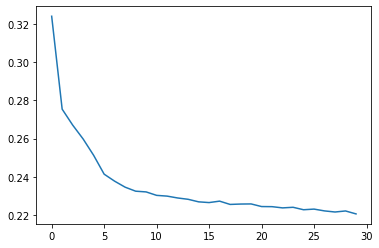

In [65]:
plt.plot(ep_list,loss_stats['train'])

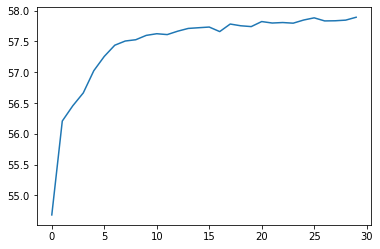

In [66]:
plt.plot(ep_list,accuracy_stats['train'])

In [67]:
# In test phase, we don't need to compute gradients
y_pred=[]
y_true=[]
with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0
    for x_batch,y_batch in test_dataloader:
         x_batch= x_batch.to(device)
         y_batch=y_batch.to(device)
         outputs = model(x_batch)
         #print(outputs.shape)
         y_batch_class=m(outputs)
         #print(y_batch_class)
         _, predicted = torch.max(y_batch_class, 1)
         #print(predicted.shape)
         #print(predicted)
         n_samples += y_batch.size(0)
         n_correct += (predicted == y_batch).sum().item()
         y_pred.append(predicted.cpu().detach().numpy())
         y_true.append(y_batch.cpu().detach().numpy())

    acc = 100.0 * (n_correct / n_samples)
    print(acc,n_correct,n_samples)

92.337 277011 300000


In [68]:
len(y_pred)

4688

In [69]:
import itertools
import numpy as np
y_p=list(itertools.chain(*y_pred))

In [70]:
len(y_p)

300000

In [71]:
y_t=list(itertools.chain(*y_true))

In [72]:
from sklearn.metrics import classification_report,accuracy_score

In [73]:
accuracy_score(y_t,y_p)

0.92337

In [74]:
print(classification_report(y_t,y_p))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    179934
         1.0       0.99      0.79      0.88    105074
         2.0       0.39      0.92      0.55     14992

    accuracy                           0.92    300000
   macro avg       0.79      0.91      0.81    300000
weighted avg       0.96      0.92      0.93    300000



## Notes 

1. One layer can be removed as performance did not improve much. 

2. HP tuning can help increase scores

3. Model in general does not overfit. Loss keeps going down but we can do early stopping at 20 epochs or so.

4. Avg train accuracy is 57%. 